In [1]:
import sys
sys.path.append('/home/nick/projects')
# from PointGPT import segmentation
from SMF_public.loader import FinDataset
import numpy as np
import pandas as pd
import os
from glob2 import glob
import plotly.express as px
import plotly.graph_objects as go
import torch
from src.utilities.functions import path_leaf
from tqdm import tqdm

In [2]:
frame_metadata_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/metadata/"
master_df = pd.read_csv(frame_metadata_root + "master_metadata.csv")

In [3]:
from sklearn.neighbors import KernelDensity
from src.utilities.fin_class_def import FinData
from alphashape import alphashape

n_sample_points = 1024
alpha = 10

# load fin objects. Keep only those that have been approved
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
seg_type = "tissue_only_best_model_tissue"
fin_object_path = os.path.join(root, "point_cloud_data", "fin_objects", "")
fin_object_list = sorted(glob(fin_object_path + "*.pkl"))
obj_prefix_list = [path_leaf(fp).replace("_fin_object.pkl", "") for fp in fin_object_list]

point_prefix = obj_prefix_list[0]

fin_stats_df = pd.DataFrame(obj_prefix_list, columns=["frame_id"])
fin_surf_list = []
fin_data_list = []

for p, point_prefix in enumerate(tqdm(obj_prefix_list)):

    fin_data = FinData(data_root=root, name=point_prefix, tissue_seg_model=seg_type)

    if fin_data.axis_body_approved and fin_data.axis_fin_approved and fin_data.seg_approved:
        fin_df = fin_data.full_point_data
        
        # get basic stats
        fin_points = fin_df.loc[fin_df["fin_label_curr"]==1, ["X", "Y", "Z"]].to_numpy()
        fin_axis_df = fin_data.axis_fin
        fin_axes = fin_data.calculate_axis_array(fin_axis_df)
        body_axes = fin_data.calculate_axis_array(fin_data.axis_body)
        

        # store stats
        fin_stats_df.loc[p, "experiment_date"] = fin_df.loc[0, "experiment_date"]
        fin_stats_df.loc[p, "well_index"] = fin_df.loc[0, "well_num"]
        fin_stats_df.loc[p, "time_index"] = fin_df.loc[0, "time_int"]

        
        if fin_points.shape[0] > 0:
            # recalculate alpha surf
            # fin_data.calculate_alpha_surf(alpha=alpha)
            
            fin_points_pca = np.matmul(fin_points - np.mean(fin_points, axis=0), fin_axes.T)
        
            scale_vec = np.max(fin_points_pca, axis=0) - np.min(fin_points_pca, axis=0)

            # fin shape and scale
            fin_stats_df.loc[p, "length_um"] = scale_vec[0]
            fin_stats_df.loc[p, "width_um"] = scale_vec[1]
            fin_stats_df.loc[p, "aspect"] = scale_vec[1] / scale_vec[0]
            
            fin_stats_df.loc[p, "n_nuclei"] = fin_points.shape[0]

            # fin orientation
            fin_stats_df.loc[p, "AP_PD_dot"] = np.dot(fin_axes[0], body_axes[0])
            fin_stats_df.loc[p, "DV_PD_dot"] = np.dot(fin_axes[0], body_axes[2])
            
            # resample
            # fit density
            kde = KernelDensity(bandwidth=0.1, kernel="gaussian").fit(fin_points_pca)
            # draw samples
            fin_data_rs = kde.sample(n_samples=1024)
            
            fin_data_list.append(fin_data_rs)

            # shift data
            min_factor = np.min(fin_points_pca)
            fin_data_norm = fin_data_rs - min_factor
            scale_factor = np.max(fin_data_norm)
            fin_data_norm = fin_data_norm / scale_factor
            fin_stats_df.loc[p, "scale_factor"] = scale_factor
            
            fin_surf = alphashape(fin_data_norm, alpha)

            vertices = fin_surf.vertices
            vertices = vertices * scale_factor
            vertices = vertices + min_factor
            fin_surf.vertices = vertices
            fin_surf_list.append(fin_surf)

            fin_stats_df.loc[p, "volume"] = np.abs(fin_surf.volume)# * scale_factor**3
            
        else:
            fin_stats_df.loc[p, "length_um"] = 0
            fin_stats_df.loc[p, "width_um"] = 0
            fin_stats_df.loc[p, "aspect"] = 0
            fin_stats_df.loc[p, "volume"] = 0
            fin_stats_df.loc[p, "n_nuclei"] = 0

            fin_stats_df.loc[p, "AP_PD_dot"] = np.nan
            fin_stats_df.loc[p, "DV_PD_dot"] = np.nan

            fin_data_list.append(fin_points_pca)

            fin_surf = alphashape(fin_points, alpha)
            fin_surf_list.append(fin_surf)

keep_indices = np.where(~np.isnan(fin_stats_df["time_index"]))[0]
fin_stats_df = fin_stats_df.loc[keep_indices, :]
fin_stats_df.reset_index(inplace=True, drop=True)

# fin_surf_list = [fin_surf_list[f] for f in keep_indices]
# join on useful data
fin_stats_df = fin_stats_df.merge(master_df.loc[:, ["time_index", "well_index", "experiment_date", "chem_i", "estimated_stage_hpf"]], 
                                  how="left", on=["experiment_date", "time_index", "well_index"])

100%|██████████| 97/97 [00:20<00:00,  4.70it/s]


### Uniformly sample points on mesh surface

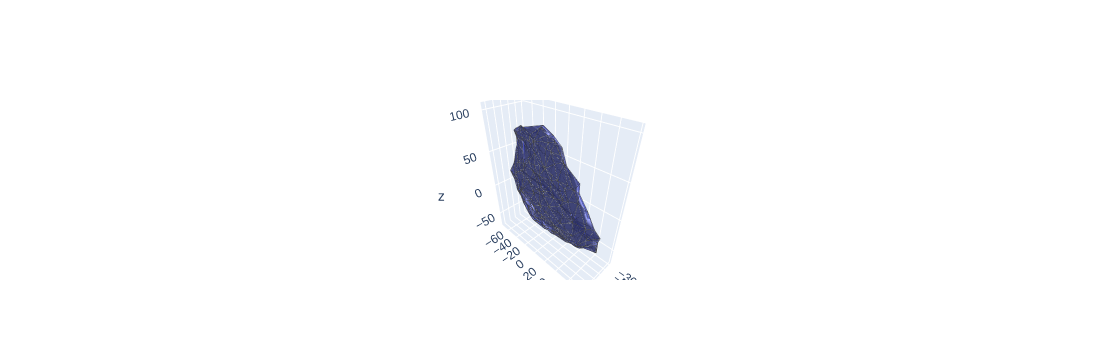

In [4]:
mesh_id = 46
plot_hull = fin_surf_list[mesh_id]

tri_points = plot_hull.vertices[plot_hull.faces]

#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])
    
       
#define the trace for triangle sides
fig = go.Figure()
lines = go.Scatter3d(
                   x=Ze,
                   y=Ye,
                   z=Xe,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=1)) 

lighting_effects = dict(ambient=0.4, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 2], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 0], 
                        opacity=0.65, i=plot_hull.faces[:, 2], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 0],
                         lighting=lighting_effects))

fig.add_trace(lines)
fig.update_layout(template="plotly")

# fig.update_layout(
#             scene=dict(
#                 zaxis=dict(autorange="reversed")))

fig.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


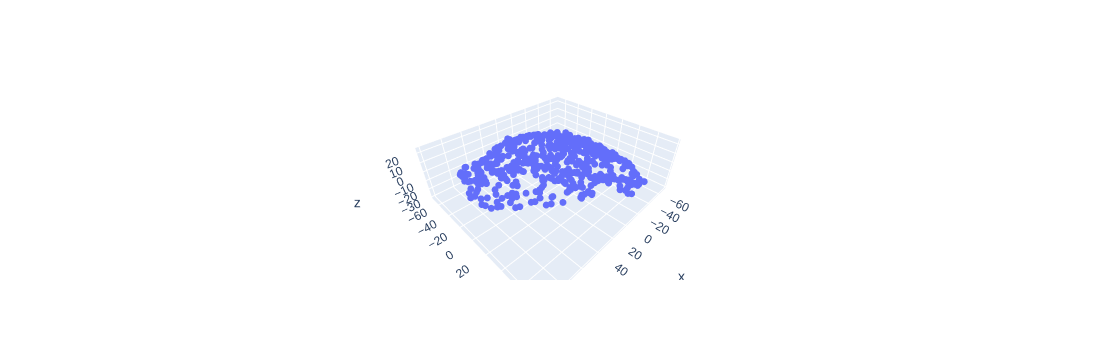

In [5]:
import open3d as o3d
import trimesh

sample_points = np.asarray(trimesh.sample.sample_surface(plot_hull, 512)[0])
fig = px.scatter_3d(x=sample_points[:, 0], y=sample_points[:, 1], z=sample_points[:, 2])
fig.update_traces(marker_size = 4)
fig.show()

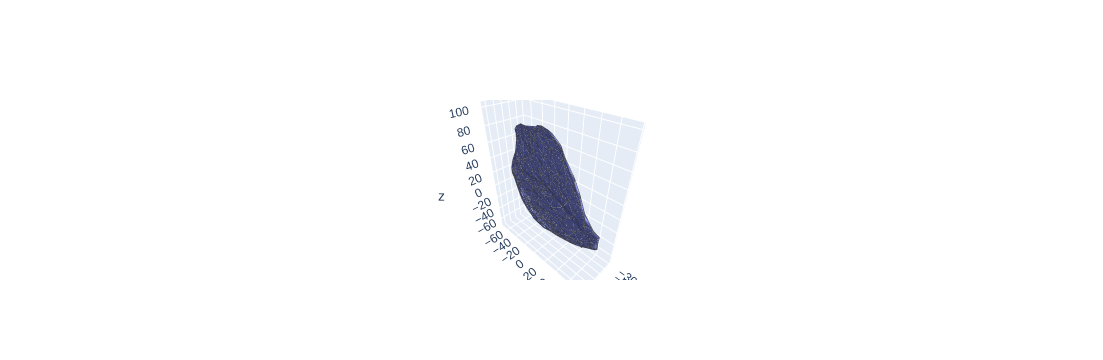

In [6]:
import trimesh
plot_id = 46
plot_hull = fin_surf_list[plot_id]
plot_hull = trimesh.smoothing.filter_laplacian(plot_hull, iterations=2)
# plot_hull = fin_surf_list[mesh_id]

tri_points = plot_hull.vertices[plot_hull.faces]

#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])
    
       
#define the trace for triangle sides
fig = go.Figure()
lines = go.Scatter3d(
                   x=Ze,
                   y=Ye,
                   z=Xe,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=1)) 

lighting_effects = dict(ambient=0.4, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 2], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 0], 
                        opacity=0.65, i=plot_hull.faces[:, 2], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 0],
                         lighting=lighting_effects))

fig.add_trace(lines)
fig.update_layout(template="plotly")


### Registration sequence

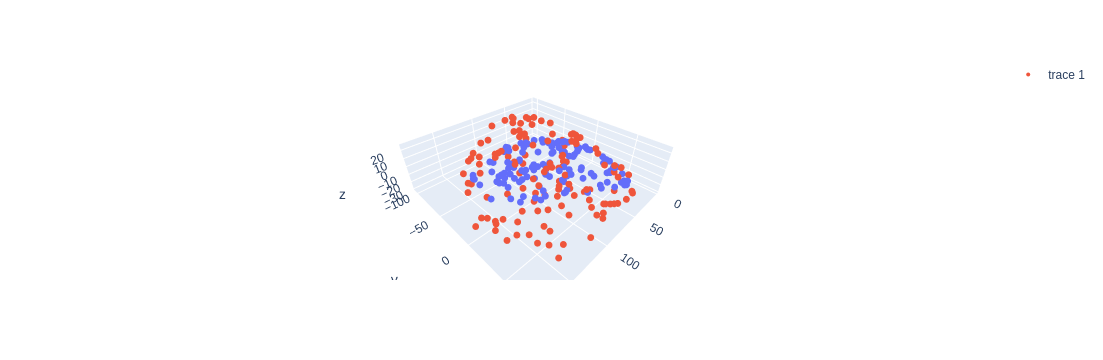

In [37]:
# set parameters
ref_id = 46
target_id = 49
n_points = 128

# smooth and sample reference mesh
ref_mesh_raw = fin_surf_list[ref_id]
ref_vertices = ref_mesh_raw.vertices # set PD zero-point
ref_vertices[:, 0] = ref_vertices[:, 0] - np.min(ref_vertices[:, 0])
ref_mesh_raw.vertices = ref_vertices
ref_mesh = trimesh.smoothing.filter_laplacian(ref_mesh_raw, iterations=2)
ref_points = ref_mesh.sample(count=n_points)

# smooth and sample target mesh
target_mesh_raw = fin_surf_list[target_id]
target_vertices = target_mesh_raw.vertices # set PD zero-point
target_vertices[:, 0] = target_vertices[:, 0] - np.min(target_vertices[:, 0])
target_mesh_raw.vertices = target_vertices
target_mesh = trimesh.smoothing.filter_laplacian(target_mesh_raw, iterations=2)
target_points = target_mesh.sample(count=n_points)


fig = px.scatter_3d(x=ref_points[:, 0], y=ref_points[:, 1], z=ref_points[:, 2])
fig.add_trace(go.Scatter3d(x=target_points[:, 0], y=target_points[:, 1], z=target_points[:, 2], mode="markers"))
fig.update_traces(marker_size = 4)
fig.show()

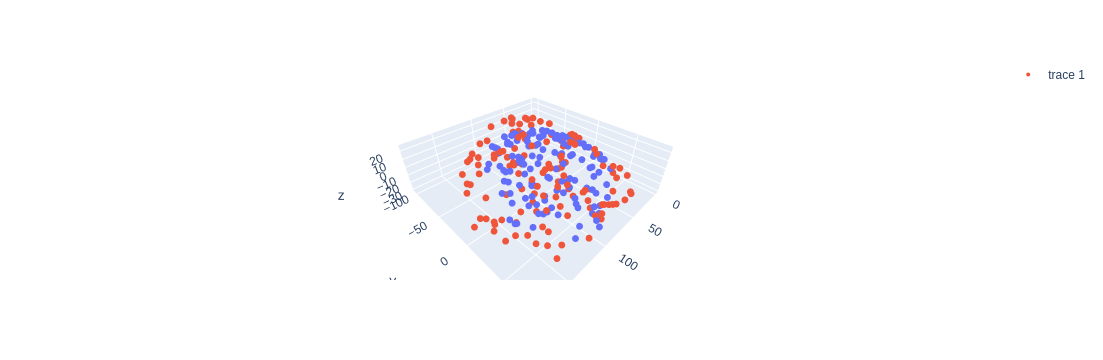

In [38]:
# perform rigid registration
from probreg import cpd
from probreg import bcpd

tf_param, _, _ = cpd.registration_cpd(ref_points, target_points, tf_type_name="rigid", update_scale=False)
result_points = ref_points.copy()
result_points = tf_param.transform(result_points)
result_points[:, 0] = result_points[:, 0] - np.min(result_points[:, 0]) # shift to PD origin

fig = px.scatter_3d(x=result_points[:, 0], y=result_points[:, 1], z=result_points[:, 2])
fig.add_trace(go.Scatter3d(x=target_points[:, 0], y=target_points[:, 1], z=target_points[:, 2], mode="markers"))
fig.update_traces(marker_size = 4)
fig.show()

2.624798536300659


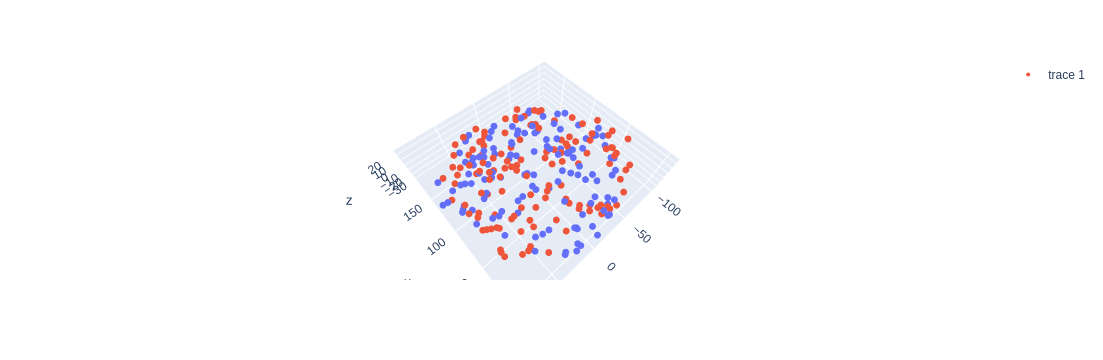

In [39]:
import time
# now, non-rigid transformation
start = time.time()
tf_param = bcpd.registration_bcpd(result_points, target_points, tol=1e-10)
print(time.time()-start)
result_points_nr = result_points.copy()
result_points_nr = tf_param.transform(result_points_nr)

# tf_param_nr, _, _ = cpd.registration_cpd(result_points, target_points, tf_type_name="nonrigid", maxiter= 5000, tol = 0.00001)
# result_points_nr = tf_param_nr.transform(result_points_nr)

fig = px.scatter_3d(x=result_points_nr[:, 0], y=result_points_nr[:, 1], z=result_points_nr[:, 2])
fig.add_trace(go.Scatter3d(x=target_points[:, 0], y=target_points[:, 1], z=target_points[:, 2], mode="markers"))
fig.update_traces(marker_size = 4)
fig.show()

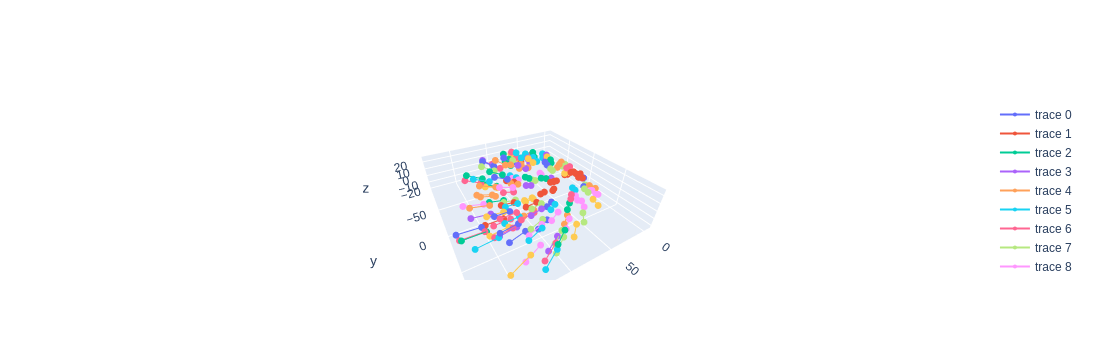

In [40]:
fig = go.Figure()
for i in range(result_points.shape[0]):
    arr = np.concatenate((result_points[i, :][np.newaxis, :], result_points_nr[i, :][np.newaxis, :]), axis=0)
    fig.add_trace(go.Scatter3d(x=arr[:, 0], y=arr[:, 1], z=arr[:, 2]))

fig.update_traces(marker_size = 4)
fig.show()

Well, that worked! The issue, though is that I cannot 